## Data Analysis

In [3]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
from PIL import Image

filters = [
    {'kernel_size': (3, 3), 'sigma': 0.3},
    {'kernel_size': (7, 7), 'sigma': 1},
    {'kernel_size': (11, 11), 'sigma': 1.6}
]


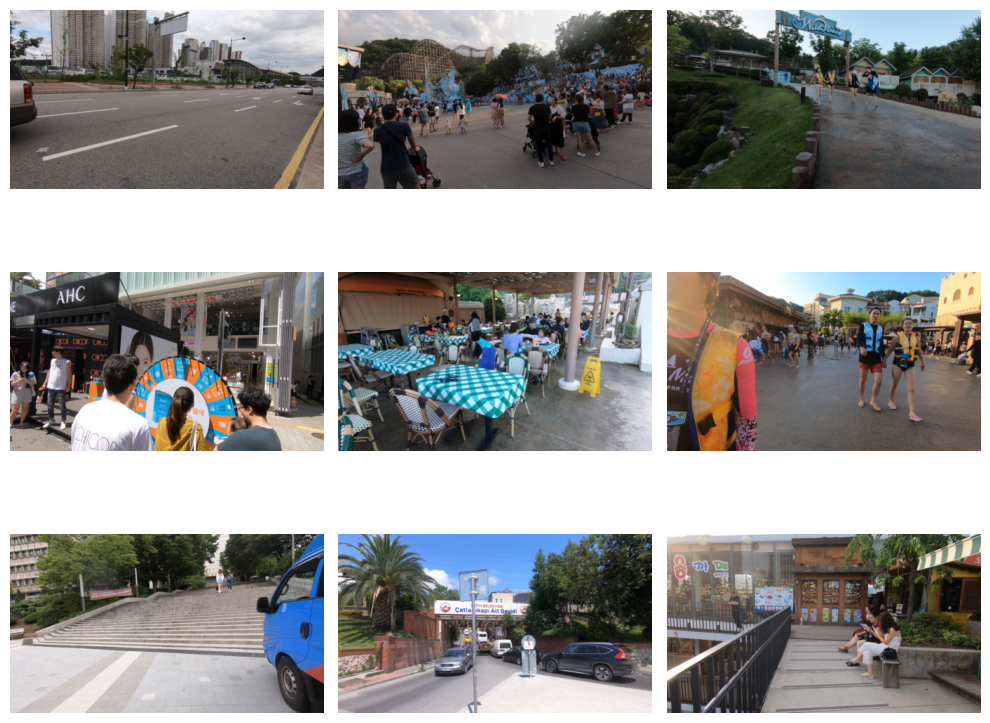

In [4]:
# Define transform to preprocess the data
transform = transforms.Compose([
    transforms.Resize((256, 448)),  # Resize images to 64x64
    transforms.ToTensor(),         # Convert images to tensors
])

# Initialize the ImageFolder dataset
training_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
m = len(training_data)


train_data, val_data = random_split(training_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0))
    plt.tight_layout()

In [5]:
def add_noise(image, filters, index):
    blurred_image = TF.gaussian_blur(original_image, kernel_size=filters[index]['kernel_size'], sigma=filters[index]['sigma'])
    return blurred_image

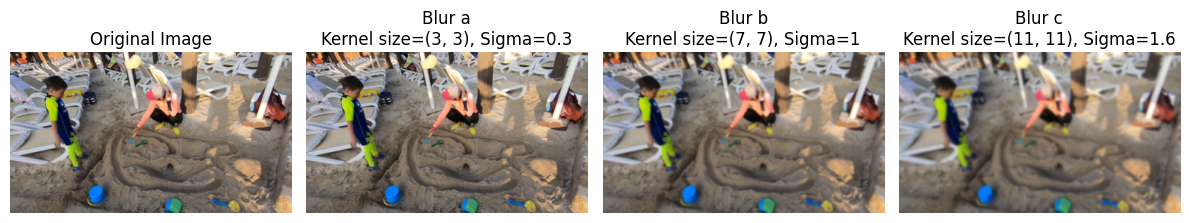

In [6]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()

original_image, _ = training_data[sample_idx]

plt.figure(figsize=(12, 4))

# Display the original image
plt.subplot(1, 4, 1)
plt.imshow(original_image.permute(1,2,0))
plt.title('Original Image')
plt.axis('off')

# Apply Gaussian blur to each filter
for i, params in enumerate(filters):
    blurred_image = add_noise(original_image, filters, i)
    plt.subplot(1, 4, i + 2)
    plt.imshow(blurred_image.permute(1,2,0))
    plt.title(f'Blur {chr(ord("a") + i)}\nKernel size={params["kernel_size"]}, Sigma={params["sigma"]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Deblurring Model Training

In [7]:
class Encoder(nn.Module):
    
    def __init__(self, input_shape = (3, 256, 448),encoded_space_dim = 256):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(64, 128, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(128 * 31 * 55, 512),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(512, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

encoder = Encoder()
print(encoder(torch.randn(1,3,256,448)).shape)

torch.Size([1, 256])


In [8]:
class Decoder(nn.Module):
    
    def __init__(self, input_shape = (3, 256, 448), encoded_space_dim = 256):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 512),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(512, 128 * 31 * 55),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128, 31, 55))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=0, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

decoder = Decoder()
print(decoder(torch.randn(1, 256)).shape)

torch.Size([1, 3, 256, 448])


In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder()
decoder = Decoder()

In [10]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=218240, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 31, 55))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  )
)

In [11]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        blur_transform = transforms.GaussianBlur(kernel_size=(3, 3), sigma=0.3)
        image_noisy = blur_transform(image_batch)
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [12]:
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            blur_transform = transforms.GaussianBlur(kernel_size=(3, 3), sigma=0.3)
            image_noisy = blur_transform(image_batch)
            image_noisy = image_noisy.to(device)
            # Encode data
            encoded_data = encoder(image_noisy)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [13]:
def plot_ae_outputs_den(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[i][0].unsqueeze(0)
      blur_transform = transforms.GaussianBlur(kernel_size=(3, 3), sigma=0.3)
      image_noisy = blur_transform(image_batch)
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

In [14]:
num_epochs = 30

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn)
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder)
    if((epoch + 1) % 5 == 0):
        torch.save(decoder.state_dict(), f'models/decoder_{epoch+1}.pt')
        torch.save(encoder.state_dict(), f'models/encoder_{epoch+1}.pt')

EPOCH 1/20
	 partial train loss (single batch): 0.101269
	 partial train loss (single batch): 0.094996


KeyboardInterrupt: 